In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.rc('font', size=30)
plt.rc('axes', titlesize=30)
plt.rc('axes', labelsize=30)
plt.rc('xtick', labelsize=30)
plt.rc('ytick', labelsize=30)
plt.rc('legend', fontsize=30)
plt.rc('figure', titlesize=30)

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.stats import norm
from scipy.stats import laplace
from scipy.stats import binom

import random
from tqdm import tqdm

In [2]:
returns = pd.read_csv('returns.csv')
returns = returns.fillna(0)
returns['date'] = returns['date'].astype(np.datetime64)
returns = returns.set_index('date')

In [3]:
returns

,MPWR,CCI,ESS,D,MRK,LYB,MLM,CAG,XEL,AMG,...,FL,ZBRA,THC,BR,EVRG,URBN,ANF,TIE,INTU,SPY
date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,0.008617,0.002673,-0.001422,-0.010919,0.015902,0.030153,0.004373,-0.004202,-0.010835,0.016249,...,0.006281,-0.001677,-0.033134,0.005345,0.000000,0.006894,0.001017,0.040086,-0.002469,0.015934
2012-01-04,-0.022360,0.002232,-0.016461,-0.008197,0.001041,0.037907,-0.000397,0.008374,-0.006582,0.002974,...,0.005409,-0.007558,-0.054445,-0.002685,0.000000,0.023784,-0.033332,-0.007093,-0.003043,0.001568
2012-01-05,0.022867,-0.000896,0.018621,-0.002108,0.010437,-0.014373,0.002369,-0.000761,0.004399,0.004400,...,0.025710,-0.001410,0.014928,0.003554,0.000000,-0.015134,-0.028995,-0.019374,0.004588,0.002663
2012-01-06,0.000000,0.001563,-0.004206,-0.010198,-0.006946,0.006150,-0.022404,-0.002664,-0.002921,-0.002133,...,0.008877,-0.008192,0.048315,-0.005259,0.000000,-0.011080,-0.021353,0.011868,0.013890,-0.002577
2012-01-09,0.026294,0.012886,-0.003637,-0.001366,-0.002110,-0.003796,0.009040,0.003818,0.000757,0.020093,...,0.002800,-0.004558,0.022043,0.007499,0.000000,0.040108,0.016019,0.005198,0.001137,0.002427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,0.022948,-0.005771,-0.001548,-0.008816,-0.004498,0.005077,0.018957,-0.010897,-0.006742,-0.000316,...,-0.033187,0.002192,0.003232,-0.009898,0.000794,-0.056878,-0.041292,0.000000,0.008123,0.002088
2021-04-27,-0.011632,-0.007309,0.000539,-0.004958,-0.002191,-0.000279,0.000361,-0.003772,-0.008512,0.018091,...,0.028386,0.006521,0.010379,0.001303,-0.009923,0.034706,0.026156,0.000000,-0.005189,-0.000216
2021-04-28,-0.019426,0.002436,-0.033900,-0.008295,-0.003492,0.013819,-0.006794,-0.001893,-0.002703,-0.009009,...,0.002375,-0.010264,0.043925,-0.001363,0.005725,0.000798,-0.000515,0.000000,-0.000768,-0.000287


In [39]:
import numpy as np
from scipy.stats import norm
from scipy.stats import binom

def norm_var(sample, window=252, alpha=0.95, n=1):
    sample = np.array(sample)
    size = len(sample) - window - n
    ans = np.zeros(size)
    for i in range(size):
        s = sample[i: i + window]
        ans[i] = norm.ppf(1 - alpha, n * np.mean(s), np.sqrt(n) * np.std(s))
    return ans

def error_count(real, pred):
    count = 0;
    for i in range(len(real)):
        if real[i] < pred[i]:
            count += 1
    return count

def error_percent(real, pred):
    return (error_count(real, pred) / len(real)) * 100

def is_norm(sample, window=252, alpha=0.95, n=1, beta=0.95):
    sample = np.array(sample)
    size = len(sample) - window - n
    norm_ans = norm_var(sample, window, alpha, n)
    real_ans = np.zeros(size)
    for i in range(window, len(sample) - n):
        for j in range(n):
            real_ans[i - window] += sample[i + j]
    count = error_count(real_ans, norm_ans)
    return count < binom.ppf(n=size, p=1-alpha, q=beta)

def norm_tickets(returns, window=252, alpha=0.95, n=1, beta=0.95):
    tickers = returns.columns
    norm_tickers = []
    for i, ticker in enumerate(tqdm(tickers)):
        sample = returns[ticker]
        if is_norm(sample, window, alpha, n, beta):
            norm_tickers.append(ticker)
    return norm_tickets

In [8]:
def Var_estimate_norm(sample, window=252, alpha=0.95, n=1, title=""):
    sample = np.array(sample)
    size = len(sample) - window - n
    norm_ans = norm_var(sample, window, alpha, n)
    x = np.arange(size)
    real_ans = np.zeros(size)
    for i in range(window, len(sample) - n):
        for j in range(n):
            real_ans[i - window] += sample[i + j]

    plt.figure(figsize=(17, 10))
    plt.title(title)
    plt.plot(x, real_ans, label="real")
    plt.plot(x, norm_ans, alpha=0.7, label="norm")
    plt.legend()
    plt.show()
    
    print("\"Пробои\" нормального VaR происходят в {}% случаев".format(round(error_percent(real_ans, norm_ans), 2)))

100%|██████████| 611/611 [12:21<00:00,  1.21s/it]


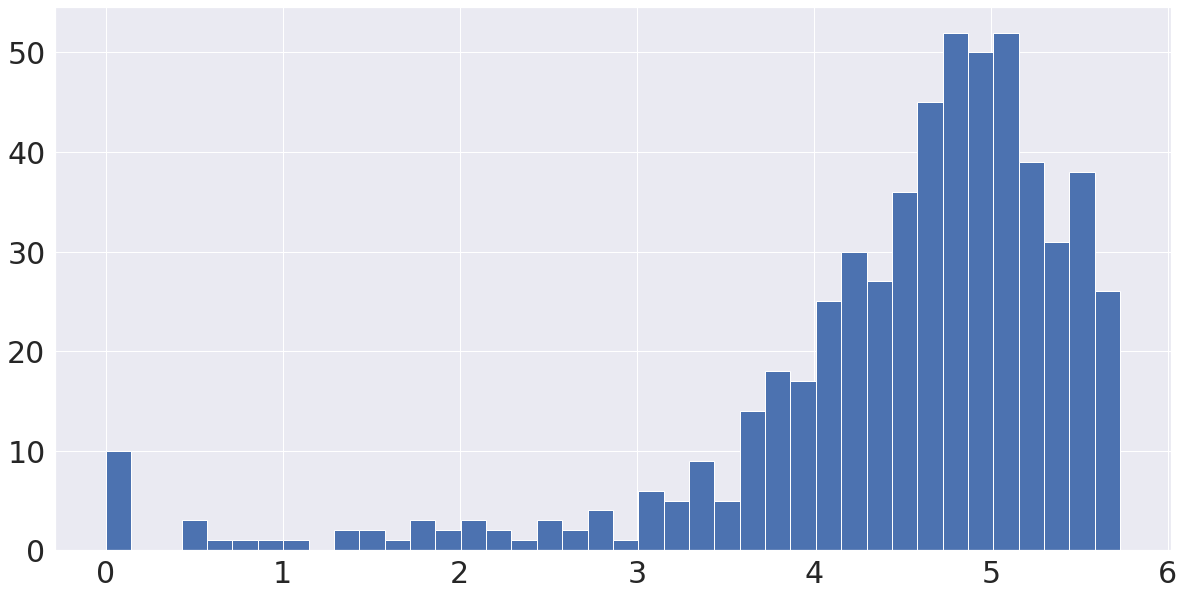

In [41]:
window = 252
alpha=0.95
beta=0.95
n = 1
tickers = returns.columns
norm_tickers = []
norm_res = []
for i, ticker in enumerate(tqdm(tickers)):
    sample = returns[ticker]
    if is_norm(sample, window, alpha, n, beta):
        norm_tickers.append(ticker)
        size = len(sample) - window - n
        real_ans = np.zeros(size)
        for i in range(window, len(sample) - n):
            for j in range(n):
                real_ans[i - window] += sample[i + j]
        norm_res.append(error_percent(real_ans, norm_var(sample)))
plt.figure(figsize=(20, 10))
plt.hist(norm_res, bins=40)
plt.show()

In [42]:
print("{} are norm from {}".format(len(norm_tickers), len(tickers)))

568 are norm from 611


100%|██████████| 611/611 [10:44<00:00,  1.06s/it]


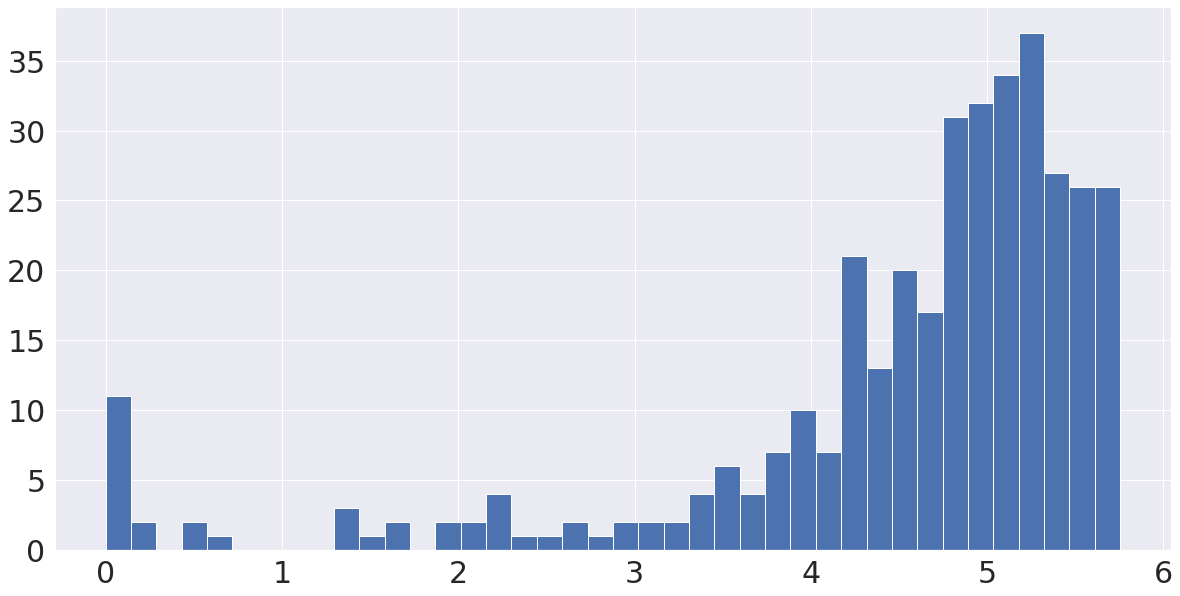

In [43]:
window = 252
alpha=0.95
beta=0.95
n = 10
tickers = returns.columns
norm_tickers_10 = []
norm_res_10 = []
for i, ticker in enumerate(tqdm(tickers)):
    sample = returns[ticker]
    if is_norm(sample, window, alpha, n, beta):
        norm_tickers_10.append(ticker)
        size = len(sample) - window - n
        real_ans = np.zeros(size)
        for i in range(window, len(sample) - n):
            for j in range(n):
                real_ans[i - window] += sample[i + j]
        norm_res_10.append(error_percent(real_ans, norm_var(sample, window, alpha, n)))
plt.figure(figsize=(20, 10))
plt.hist(norm_res_10, bins=40)
plt.show()

In [44]:
print("{} are norm from {}".format(len(norm_tickers_10), len(tickers)))

363 are norm from 611
